In [2]:
!pip install torch torchvision matplotlib opencv-python timm tqdm

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import timm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from google.colab import drive

drive.mount('/content/drive')

drive_dir = """/content/drive/MyDrive/KoreaUniv/2024/DEEP_LEARNING/Final_Project"""

Mounted at /content/drive


## dataset

In [6]:
data_dir = drive_dir + "/datasets/Office-31/domain_adaptation_images"

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [8]:
batch_size = 32
learning_rate = 1e-4
num_epochs = 20

In [9]:
amazon_dir = data_dir + '/amazon/images'
dslr_dir = data_dir + '/dslr/images'
webcam_dir = data_dir + '/webcam/images'

amazon_dataset = datasets.ImageFolder(root=amazon_dir, transform=transform)
dslr_dataset = datasets.ImageFolder(root=dslr_dir, transform=transform)
webcam_dataset = datasets.ImageFolder(root=webcam_dir, transform=transform)

In [10]:
classes = amazon_dataset.classes

In [11]:
print(len(amazon_dataset))
print(len(dslr_dataset))
print(len(webcam_dataset))

2817
498
795


In [12]:
def split_dataset(dataset, train_ratio=0.8):
    train_size = int(train_ratio * len(dataset))
    valid_size = len(dataset) - train_size

    train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader

In [13]:
amazon_train_loader, amazon_valid_loader = split_dataset(amazon_dataset)
dslr_train_loader, dslr_valid_loader = split_dataset(dslr_dataset)
webcam_train_loader, webcam_valid_loader = split_dataset(webcam_dataset)

In [14]:
amazon_loader = DataLoader(amazon_dataset, batch_size=batch_size, shuffle=True)
dslr_loader = DataLoader(dslr_dataset, batch_size=batch_size, shuffle=True)
webcam_loader = DataLoader(webcam_dataset, batch_size=batch_size, shuffle=True)

### visualize samples

In [15]:
def imshow(img, title):
    img = img / 2 + 0.5  # 정규화 해제!!
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

In [16]:
def visualize_samples(dataloader, domain_name, classes, num_images=5):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    plt.figure(figsize=(15, 5))
    for idx in range(num_images):
        plt.subplot(1, num_images, idx+1)
        imshow(images[idx], title=f"{domain_name} - {classes[int(labels[idx])]}[{labels[idx]}]")
    plt.show()

Visualizing Amazon Samples


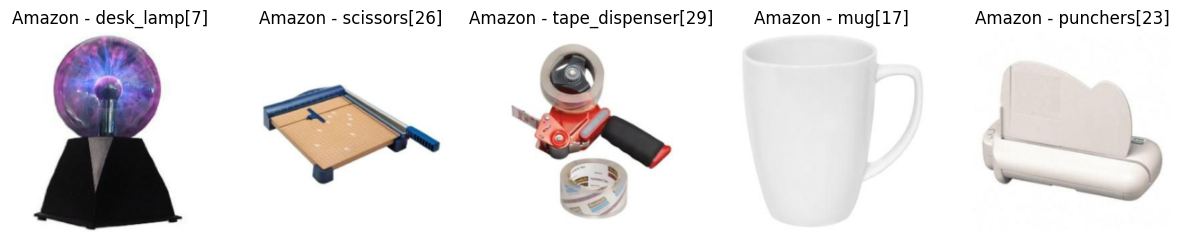

Visualizing DSLR Samples...


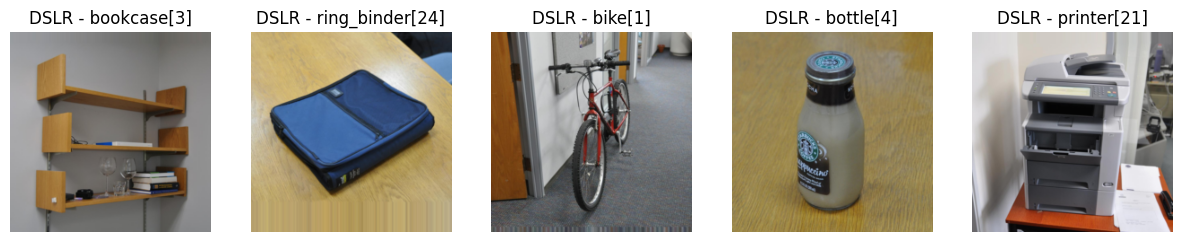

Visualizing Webcam Samples


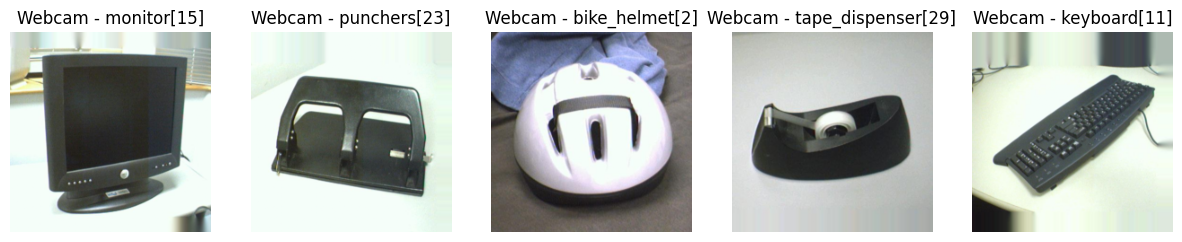

In [ ]:
print("Visualizing Amazon Samples")
visualize_samples(amazon_train_loader, domain_name="Amazon", classes=classes)

print("Visualizing DSLR Samples...")
visualize_samples(dslr_train_loader, domain_name="DSLR", classes=classes)

print("Visualizing Webcam Samples")
visualize_samples(webcam_train_loader, domain_name="Webcam", classes=classes)

## ViT Domain Adaptation

### Model

In [17]:
class ViTDomainAdaptation(nn.Module):
    def __init__(self, num_classes):
        super(ViTDomainAdaptation, self).__init__()
        self.feature_extractor = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=0)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        outputs = self.fc(features)
        return features, outputs

In [18]:
def coral_loss(source, target):
    d = source.size(1)
    source_cov = torch.mm(source.T, source) / source.size(0)
    target_cov = torch.mm(target.T, target) / target.size(0)
    loss = torch.norm(source_cov - target_cov, p="fro") ** 2 / (4 * d * d)
    return loss

### Training

In [19]:
def train_model(model, source_train_loader, source_valid_loader, target_loader, domain_pair, num_epochs, learning_rate):
    print(f"Train {domain_pair[0]} -> {domain_pair[1]}")

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    classification_loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        # train
        model.train()
        total_loss, total_class_loss, total_coral_loss = 0, 0, 0

        source_iter = iter(source_train_loader)
        target_iter = iter(target_loader)

        for _ in tqdm(range(min(len(source_train_loader), len(target_loader)))):
            source_data, source_labels = next(source_iter)
            target_data, _ = next(target_iter)

            source_data, source_labels = source_data.to(device), source_labels.to(device)
            target_data = target_data.to(device)

            source_features, source_preds = model(source_data)
            target_features, _ = model(target_data)

            class_loss = classification_loss(source_preds, source_labels)
            domain_loss = coral_loss(source_features, target_features)

            # Trade-off
            loss = class_loss + 0.1 * domain_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_class_loss += class_loss.item()
            total_coral_loss += domain_loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss:.4f}, Class Loss: {total_class_loss:.4f}, Coral Loss: {total_coral_loss:.4f}")

        # valid
        model.eval()
        valid_loss = 0
        correct = 0
        with torch.no_grad():
            for data, labels in source_valid_loader:
                data, labels = data.to(device), labels.to(device)
                _, outputs = model(data)
                loss = classification_loss(outputs, labels)
                valid_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()

        valid_accuracy = 100 * correct / len(source_valid_loader.dataset)
        print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%")

### Evaluating

In [20]:
def evaluate_model(model, target_loader, domain_pair):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, labels in target_loader:
            data, labels = data.to(device), labels.to(device)
            _, outputs = model(data)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    print(f"Accuracy of {domain_pair[0]} model on {domain_pair[1]} domain: {100 * correct / total:.2f}%")

### Visualize results

In [21]:
# predicted samples
def visualize_predictions(model, dataloader, device, classes, num_images=5):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 5))
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            _, outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break
                plt.subplot(1, num_images, images_shown + 1)
                img = images[i].cpu().numpy().transpose((1, 2, 0))
                img = img / 2 + 0.5
                plt.imshow(img)
                plt.title(f"True: {classes[labels[i]]}\nPred: {classes[preds[i]]}")
                plt.axis('off')
                images_shown += 1
            if images_shown >= num_images:
                break
    plt.show()

In [22]:
# confusion matrix
def plot_confusion_matrix(model, dataloader, device, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            _, outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

In [23]:
def show_results(model, source_loader, target_loader, domain_pair, device, classes):
    print(f"Visualizing {domain_pair[0]} model on {domain_pair[1]} domain")
    visualize_predictions(model, target_loader, device, classes, num_images=5)

    evaluate_model(model, source_loader, (domain_pair[0], domain_pair[0]))
    plot_confusion_matrix(model, source_loader, device, classes)

    evaluate_model(model, target_loader, domain_pair)
    plot_confusion_matrix(model, target_loader, device, classes)

### experiment set

In [24]:
def construct_experiment(model, source_loader, source_train_loader, source_valid_loader, target_loader, domain_pair, device, num_epochs, learning_rate):
    print(f"{domain_pair[0]} model on {domain_pair[1]} domain")
    train_model(model, source_train_loader, source_valid_loader, target_loader, domain_pair, num_epochs, learning_rate)
    show_results(model, source_loader, target_loader, domain_pair, device, classes)

## Experiment

### Amazon

In [ ]:
# Amazon
model = ViTDomainAdaptation(num_classes=len(classes)).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Amazon model on DSLR domain
Train Amazon -> DSLR


100%|██████████| 16/16 [11:03<00:00, 41.47s/it]


Epoch [1/20], Total Loss: 35.8270, Class Loss: 35.2859, Coral Loss: 5.4114
Validation Loss: 17.8619, Validation Accuracy: 72.16%


100%|██████████| 16/16 [04:39<00:00, 17.47s/it]


Epoch [2/20], Total Loss: 10.1591, Class Loss: 9.6570, Coral Loss: 5.0215
Validation Loss: 12.8268, Validation Accuracy: 79.43%


100%|██████████| 16/16 [04:02<00:00, 15.14s/it]


Epoch [3/20], Total Loss: 8.8030, Class Loss: 8.4945, Coral Loss: 3.0853
Validation Loss: 12.8642, Validation Accuracy: 79.96%


100%|██████████| 16/16 [02:51<00:00, 10.71s/it]


Epoch [4/20], Total Loss: 7.5223, Class Loss: 7.2454, Coral Loss: 2.7693
Validation Loss: 10.5363, Validation Accuracy: 84.22%


100%|██████████| 16/16 [02:20<00:00,  8.79s/it]


Epoch [5/20], Total Loss: 6.5427, Class Loss: 6.3073, Coral Loss: 2.3543
Validation Loss: 11.2511, Validation Accuracy: 83.16%


100%|██████████| 16/16 [01:59<00:00,  7.49s/it]


Epoch [6/20], Total Loss: 4.5185, Class Loss: 4.1858, Coral Loss: 3.3268
Validation Loss: 8.3523, Validation Accuracy: 86.70%


100%|██████████| 16/16 [01:37<00:00,  6.11s/it]


Epoch [7/20], Total Loss: 3.5202, Class Loss: 3.2938, Coral Loss: 2.2644
Validation Loss: 8.2350, Validation Accuracy: 88.12%


100%|██████████| 16/16 [01:15<00:00,  4.71s/it]


Epoch [8/20], Total Loss: 3.8250, Class Loss: 3.5879, Coral Loss: 2.3712
Validation Loss: 9.6061, Validation Accuracy: 85.82%


100%|██████████| 16/16 [01:03<00:00,  3.95s/it]


Epoch [9/20], Total Loss: 2.4700, Class Loss: 2.2589, Coral Loss: 2.1108
Validation Loss: 9.9080, Validation Accuracy: 84.22%


100%|██████████| 16/16 [00:42<00:00,  2.68s/it]


Epoch [10/20], Total Loss: 1.9436, Class Loss: 1.7111, Coral Loss: 2.3244
Validation Loss: 8.9059, Validation Accuracy: 87.41%


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [11/20], Total Loss: 1.8314, Class Loss: 1.5735, Coral Loss: 2.5791
Validation Loss: 9.1127, Validation Accuracy: 87.06%


100%|██████████| 16/16 [00:37<00:00,  2.36s/it]


Epoch [12/20], Total Loss: 2.6490, Class Loss: 2.4632, Coral Loss: 1.8582
Validation Loss: 8.1970, Validation Accuracy: 87.94%


100%|██████████| 16/16 [00:32<00:00,  2.06s/it]


Epoch [13/20], Total Loss: 1.5410, Class Loss: 1.3484, Coral Loss: 1.9262
Validation Loss: 8.2165, Validation Accuracy: 88.65%


100%|██████████| 16/16 [00:27<00:00,  1.70s/it]


Epoch [14/20], Total Loss: 1.3319, Class Loss: 1.1245, Coral Loss: 2.0747
Validation Loss: 10.1258, Validation Accuracy: 87.59%


100%|██████████| 16/16 [00:24<00:00,  1.53s/it]


Epoch [15/20], Total Loss: 1.1197, Class Loss: 0.9214, Coral Loss: 1.9834
Validation Loss: 10.2839, Validation Accuracy: 86.17%


100%|██████████| 16/16 [00:20<00:00,  1.28s/it]


Epoch [16/20], Total Loss: 0.9977, Class Loss: 0.8120, Coral Loss: 1.8565
Validation Loss: 8.4222, Validation Accuracy: 89.54%


100%|██████████| 16/16 [00:20<00:00,  1.27s/it]


Epoch [17/20], Total Loss: 0.9591, Class Loss: 0.7554, Coral Loss: 2.0372
Validation Loss: 11.5784, Validation Accuracy: 85.11%


100%|██████████| 16/16 [00:20<00:00,  1.26s/it]


Epoch [18/20], Total Loss: 1.2084, Class Loss: 1.0305, Coral Loss: 1.7798
Validation Loss: 11.5043, Validation Accuracy: 85.28%


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


Epoch [19/20], Total Loss: 1.2568, Class Loss: 1.1130, Coral Loss: 1.4388
Validation Loss: 10.4255, Validation Accuracy: 85.82%


100%|██████████| 16/16 [00:20<00:00,  1.28s/it]


Epoch [20/20], Total Loss: 0.6281, Class Loss: 0.4555, Coral Loss: 1.7259
Validation Loss: 10.2195, Validation Accuracy: 86.17%
Visualizing Amazon model on DSLR domain


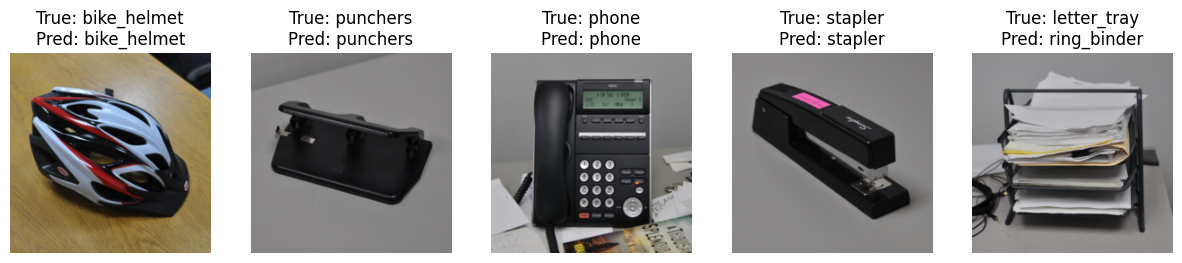

Accuracy of Amazon model on Amazon domain: 96.49%


<Figure size 1000x800 with 0 Axes>

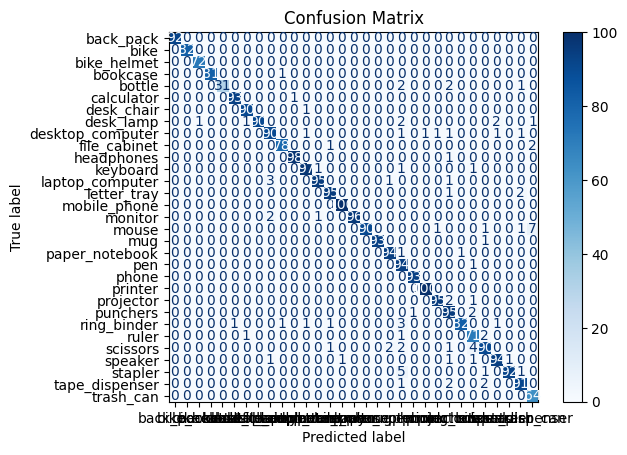

Accuracy of Amazon model on DSLR domain: 76.91%


<Figure size 1000x800 with 0 Axes>

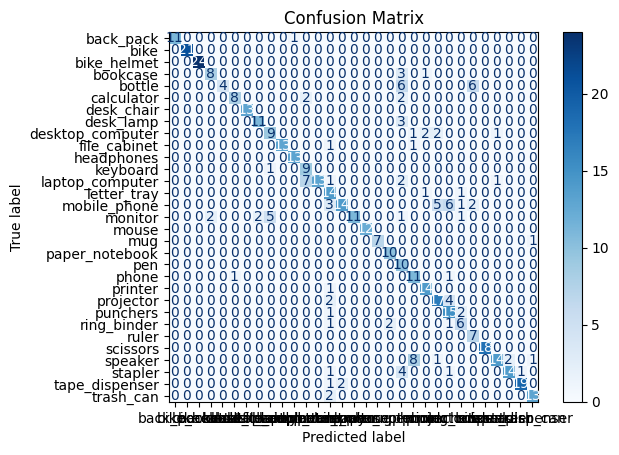

In [ ]:
construct_experiment(model, amazon_loader, amazon_train_loader, amazon_valid_loader, dslr_loader, ("Amazon", "DSLR"), device, num_epochs, learning_rate)

Amazon model on Webcam domain
Train Amazon -> Webcam


100%|██████████| 25/25 [09:06<00:00, 21.86s/it]


Epoch [1/20], Total Loss: 40.7875, Class Loss: 40.1257, Coral Loss: 6.6176
Validation Loss: 13.8282, Validation Accuracy: 78.72%


100%|██████████| 25/25 [00:20<00:00,  1.25it/s]


Epoch [2/20], Total Loss: 17.3411, Class Loss: 16.8297, Coral Loss: 5.1133
Validation Loss: 10.9289, Validation Accuracy: 83.87%


100%|██████████| 25/25 [00:19<00:00,  1.27it/s]


Epoch [3/20], Total Loss: 9.4225, Class Loss: 9.0117, Coral Loss: 4.1088
Validation Loss: 9.6157, Validation Accuracy: 85.28%


100%|██████████| 25/25 [00:19<00:00,  1.26it/s]


Epoch [4/20], Total Loss: 5.1450, Class Loss: 4.6983, Coral Loss: 4.4676
Validation Loss: 10.3113, Validation Accuracy: 86.17%


100%|██████████| 25/25 [00:19<00:00,  1.27it/s]


Epoch [5/20], Total Loss: 6.9239, Class Loss: 6.5669, Coral Loss: 3.5703
Validation Loss: 8.6322, Validation Accuracy: 88.12%


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Epoch [6/20], Total Loss: 4.7749, Class Loss: 4.4015, Coral Loss: 3.7336
Validation Loss: 9.3194, Validation Accuracy: 85.99%


100%|██████████| 25/25 [00:19<00:00,  1.27it/s]


Epoch [7/20], Total Loss: 3.3315, Class Loss: 2.9630, Coral Loss: 3.6845
Validation Loss: 11.0476, Validation Accuracy: 84.57%


100%|██████████| 25/25 [00:19<00:00,  1.27it/s]


Epoch [8/20], Total Loss: 2.7028, Class Loss: 2.3338, Coral Loss: 3.6900
Validation Loss: 9.9430, Validation Accuracy: 87.59%


100%|██████████| 25/25 [00:19<00:00,  1.27it/s]


Epoch [9/20], Total Loss: 1.9401, Class Loss: 1.5906, Coral Loss: 3.4948
Validation Loss: 11.1033, Validation Accuracy: 85.64%


100%|██████████| 25/25 [00:19<00:00,  1.27it/s]


Epoch [10/20], Total Loss: 2.1480, Class Loss: 1.8035, Coral Loss: 3.4445
Validation Loss: 9.8477, Validation Accuracy: 87.59%


100%|██████████| 25/25 [00:19<00:00,  1.26it/s]


Epoch [11/20], Total Loss: 1.6076, Class Loss: 1.3290, Coral Loss: 2.7860
Validation Loss: 8.4230, Validation Accuracy: 88.48%


100%|██████████| 25/25 [00:19<00:00,  1.27it/s]


Epoch [12/20], Total Loss: 1.4988, Class Loss: 1.1983, Coral Loss: 3.0048
Validation Loss: 11.6333, Validation Accuracy: 85.64%


100%|██████████| 25/25 [00:19<00:00,  1.26it/s]


Epoch [13/20], Total Loss: 1.7542, Class Loss: 1.4687, Coral Loss: 2.8545
Validation Loss: 10.1694, Validation Accuracy: 87.41%


100%|██████████| 25/25 [00:19<00:00,  1.27it/s]


Epoch [14/20], Total Loss: 2.4302, Class Loss: 2.1898, Coral Loss: 2.4037
Validation Loss: 12.5121, Validation Accuracy: 83.69%


100%|██████████| 25/25 [00:19<00:00,  1.26it/s]


Epoch [15/20], Total Loss: 1.9701, Class Loss: 1.7030, Coral Loss: 2.6710
Validation Loss: 10.9328, Validation Accuracy: 86.52%


100%|██████████| 25/25 [00:19<00:00,  1.26it/s]


Epoch [16/20], Total Loss: 0.8118, Class Loss: 0.5355, Coral Loss: 2.7628
Validation Loss: 9.8351, Validation Accuracy: 88.30%


100%|██████████| 25/25 [00:19<00:00,  1.25it/s]


Epoch [17/20], Total Loss: 0.9612, Class Loss: 0.7205, Coral Loss: 2.4070
Validation Loss: 9.8262, Validation Accuracy: 87.94%


100%|██████████| 25/25 [00:19<00:00,  1.25it/s]


Epoch [18/20], Total Loss: 1.0300, Class Loss: 0.8433, Coral Loss: 1.8663
Validation Loss: 10.4258, Validation Accuracy: 87.23%


100%|██████████| 25/25 [00:19<00:00,  1.25it/s]


Epoch [19/20], Total Loss: 1.1884, Class Loss: 0.9432, Coral Loss: 2.4521
Validation Loss: 11.0851, Validation Accuracy: 86.70%


100%|██████████| 25/25 [00:19<00:00,  1.27it/s]


Epoch [20/20], Total Loss: 0.6727, Class Loss: 0.4898, Coral Loss: 1.8288
Validation Loss: 10.2816, Validation Accuracy: 87.23%
Visualizing Amazon model on Webcam domain


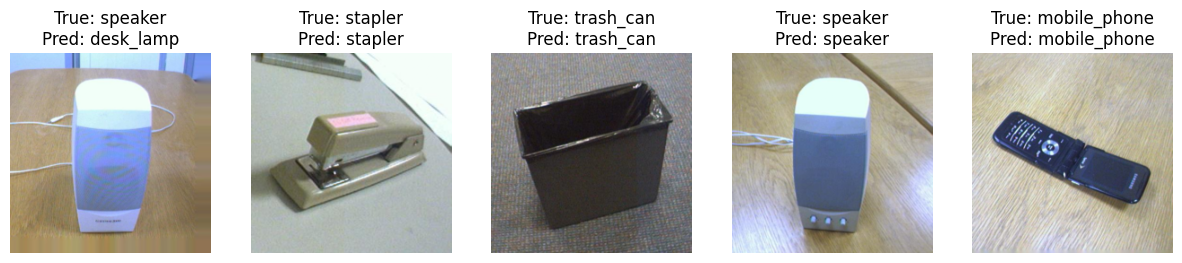

Accuracy of Amazon model on Amazon domain: 97.20%


<Figure size 1000x800 with 0 Axes>

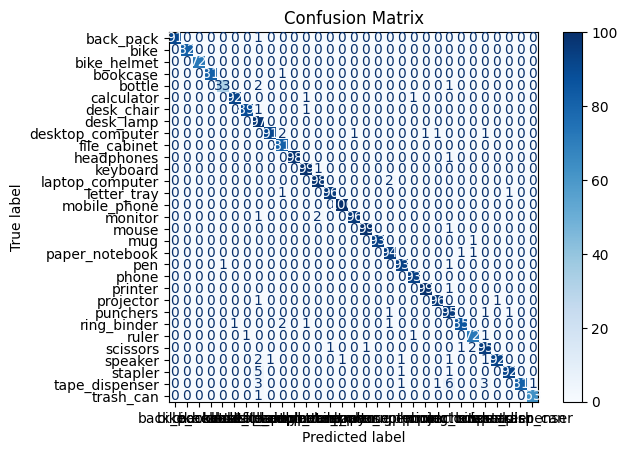

Accuracy of Amazon model on Webcam domain: 76.23%


<Figure size 1000x800 with 0 Axes>

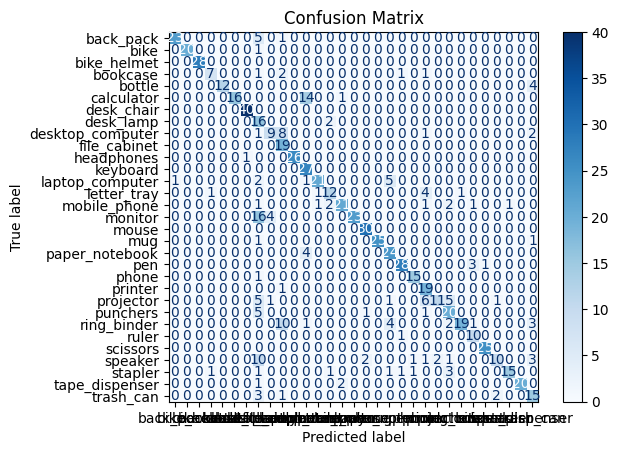

In [ ]:
model = ViTDomainAdaptation(num_classes=len(classes)).to(device)
construct_experiment(model, amazon_loader, amazon_train_loader, amazon_valid_loader, webcam_loader, ("Amazon", "Webcam"), device, num_epochs, learning_rate)

### DSLR

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

DSLR model on Amazon domain
Train DSLR -> Amazon


100%|██████████| 13/13 [03:40<00:00, 17.00s/it]


Epoch [1/20], Total Loss: 20.9967, Class Loss: 20.6617, Coral Loss: 3.3498
Validation Loss: 0.6589, Validation Accuracy: 96.00%


100%|██████████| 13/13 [01:30<00:00,  6.96s/it]


Epoch [2/20], Total Loss: 1.1989, Class Loss: 0.8023, Coral Loss: 3.9652
Validation Loss: 0.9405, Validation Accuracy: 92.00%


100%|██████████| 13/13 [01:26<00:00,  6.65s/it]


Epoch [3/20], Total Loss: 0.9930, Class Loss: 0.7275, Coral Loss: 2.6549
Validation Loss: 0.1878, Validation Accuracy: 99.00%


100%|██████████| 13/13 [01:13<00:00,  5.64s/it]


Epoch [4/20], Total Loss: 0.7197, Class Loss: 0.4957, Coral Loss: 2.2402
Validation Loss: 0.8279, Validation Accuracy: 95.00%


100%|██████████| 13/13 [01:07<00:00,  5.16s/it]


Epoch [5/20], Total Loss: 0.3675, Class Loss: 0.1735, Coral Loss: 1.9399
Validation Loss: 0.2876, Validation Accuracy: 98.00%


100%|██████████| 13/13 [00:57<00:00,  4.45s/it]


Epoch [6/20], Total Loss: 0.2436, Class Loss: 0.0833, Coral Loss: 1.6038
Validation Loss: 0.2256, Validation Accuracy: 99.00%


100%|██████████| 13/13 [00:52<00:00,  4.03s/it]


Epoch [7/20], Total Loss: 0.1495, Class Loss: 0.0476, Coral Loss: 1.0185
Validation Loss: 0.2067, Validation Accuracy: 99.00%


100%|██████████| 13/13 [00:44<00:00,  3.44s/it]


Epoch [8/20], Total Loss: 0.1345, Class Loss: 0.0341, Coral Loss: 1.0047
Validation Loss: 0.1840, Validation Accuracy: 99.00%


100%|██████████| 13/13 [00:46<00:00,  3.61s/it]


Epoch [9/20], Total Loss: 0.1154, Class Loss: 0.0270, Coral Loss: 0.8835
Validation Loss: 0.1891, Validation Accuracy: 99.00%


100%|██████████| 13/13 [00:35<00:00,  2.77s/it]


Epoch [10/20], Total Loss: 0.1081, Class Loss: 0.0271, Coral Loss: 0.8094
Validation Loss: 0.1890, Validation Accuracy: 99.00%


100%|██████████| 13/13 [00:32<00:00,  2.51s/it]


Epoch [11/20], Total Loss: 0.1022, Class Loss: 0.0263, Coral Loss: 0.7591
Validation Loss: 0.1874, Validation Accuracy: 99.00%


100%|██████████| 13/13 [00:29<00:00,  2.24s/it]


Epoch [12/20], Total Loss: 0.0932, Class Loss: 0.0235, Coral Loss: 0.6963
Validation Loss: 0.1769, Validation Accuracy: 99.00%


100%|██████████| 13/13 [00:26<00:00,  2.06s/it]


Epoch [13/20], Total Loss: 0.0864, Class Loss: 0.0213, Coral Loss: 0.6510
Validation Loss: 0.1742, Validation Accuracy: 99.00%


100%|██████████| 13/13 [00:25<00:00,  1.99s/it]


Epoch [14/20], Total Loss: 0.0798, Class Loss: 0.0202, Coral Loss: 0.5960
Validation Loss: 0.1707, Validation Accuracy: 99.00%


100%|██████████| 13/13 [00:23<00:00,  1.77s/it]


Epoch [15/20], Total Loss: 0.0787, Class Loss: 0.0191, Coral Loss: 0.5959
Validation Loss: 0.1686, Validation Accuracy: 99.00%


100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


Epoch [16/20], Total Loss: 0.0693, Class Loss: 0.0183, Coral Loss: 0.5095
Validation Loss: 0.1535, Validation Accuracy: 99.00%


100%|██████████| 13/13 [00:23<00:00,  1.79s/it]


Epoch [17/20], Total Loss: 0.0658, Class Loss: 0.0160, Coral Loss: 0.4976
Validation Loss: 0.1513, Validation Accuracy: 99.00%


100%|██████████| 13/13 [00:21<00:00,  1.69s/it]


Epoch [18/20], Total Loss: 0.0685, Class Loss: 0.0164, Coral Loss: 0.5214
Validation Loss: 0.1602, Validation Accuracy: 99.00%


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch [19/20], Total Loss: 0.0625, Class Loss: 0.0164, Coral Loss: 0.4606
Validation Loss: 0.1484, Validation Accuracy: 99.00%


100%|██████████| 13/13 [00:19<00:00,  1.54s/it]


Epoch [20/20], Total Loss: 0.0588, Class Loss: 0.0135, Coral Loss: 0.4530
Validation Loss: 0.1434, Validation Accuracy: 99.00%
Visualizing DSLR model on Amazon domain


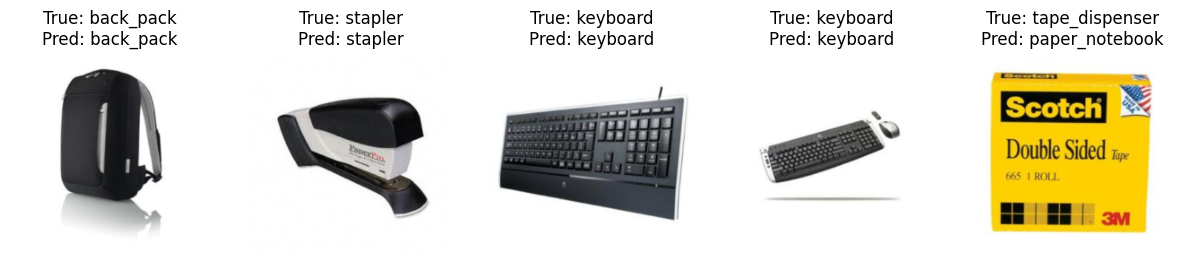

Accuracy of DSLR model on DSLR domain: 99.80%


<Figure size 1000x800 with 0 Axes>

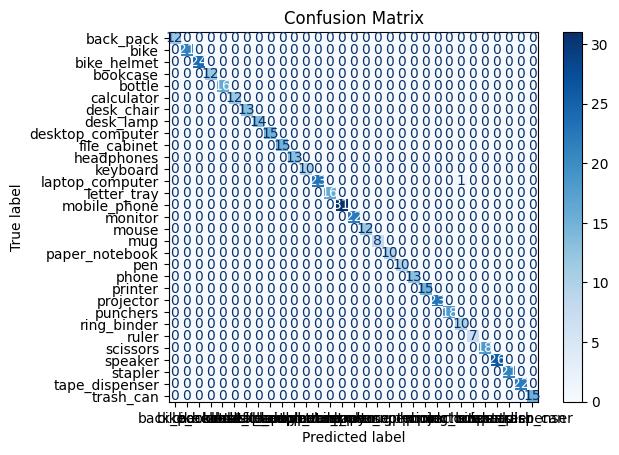

Accuracy of DSLR model on Amazon domain: 65.60%


<Figure size 1000x800 with 0 Axes>

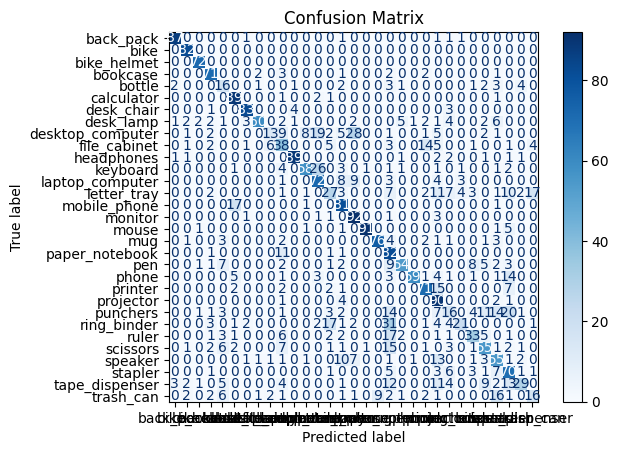

In [25]:
model = ViTDomainAdaptation(num_classes=len(classes)).to(device)
construct_experiment(model, dslr_loader, dslr_train_loader, dslr_valid_loader, amazon_loader, ("DSLR", "Amazon"), device, num_epochs, learning_rate)

DSLR model on Webcam domain
Train DSLR -> Webcam


100%|██████████| 13/13 [00:14<00:00,  1.08s/it]


Epoch [1/20], Total Loss: 19.9489, Class Loss: 19.5496, Coral Loss: 3.9927
Validation Loss: 0.6340, Validation Accuracy: 97.00%


100%|██████████| 13/13 [00:13<00:00,  1.05s/it]


Epoch [2/20], Total Loss: 1.4296, Class Loss: 0.9750, Coral Loss: 4.5466
Validation Loss: 0.9112, Validation Accuracy: 94.00%


100%|██████████| 13/13 [00:13<00:00,  1.05s/it]


Epoch [3/20], Total Loss: 0.5141, Class Loss: 0.2523, Coral Loss: 2.6179
Validation Loss: 0.2592, Validation Accuracy: 98.00%


100%|██████████| 13/13 [00:13<00:00,  1.04s/it]


Epoch [4/20], Total Loss: 0.3335, Class Loss: 0.1375, Coral Loss: 1.9599
Validation Loss: 0.3959, Validation Accuracy: 97.00%


100%|██████████| 13/13 [00:13<00:00,  1.05s/it]


Epoch [5/20], Total Loss: 0.1876, Class Loss: 0.0534, Coral Loss: 1.3419
Validation Loss: 0.1792, Validation Accuracy: 99.00%


100%|██████████| 13/13 [00:13<00:00,  1.05s/it]


Epoch [6/20], Total Loss: 0.1592, Class Loss: 0.0341, Coral Loss: 1.2515
Validation Loss: 0.1478, Validation Accuracy: 99.00%


100%|██████████| 13/13 [00:13<00:00,  1.04s/it]


Epoch [7/20], Total Loss: 0.1176, Class Loss: 0.0335, Coral Loss: 0.8405
Validation Loss: 0.1409, Validation Accuracy: 98.00%


100%|██████████| 13/13 [00:13<00:00,  1.05s/it]


Epoch [8/20], Total Loss: 0.1094, Class Loss: 0.0259, Coral Loss: 0.8350
Validation Loss: 0.1369, Validation Accuracy: 98.00%


100%|██████████| 13/13 [00:13<00:00,  1.06s/it]


Epoch [9/20], Total Loss: 0.1030, Class Loss: 0.0242, Coral Loss: 0.7874
Validation Loss: 0.1391, Validation Accuracy: 98.00%


100%|██████████| 13/13 [00:13<00:00,  1.05s/it]


Epoch [10/20], Total Loss: 0.0945, Class Loss: 0.0245, Coral Loss: 0.6992
Validation Loss: 0.1305, Validation Accuracy: 98.00%


100%|██████████| 13/13 [00:13<00:00,  1.05s/it]


Epoch [11/20], Total Loss: 0.0896, Class Loss: 0.0234, Coral Loss: 0.6620
Validation Loss: 0.1234, Validation Accuracy: 99.00%


100%|██████████| 13/13 [00:13<00:00,  1.04s/it]


Epoch [12/20], Total Loss: 0.0804, Class Loss: 0.0204, Coral Loss: 0.6005
Validation Loss: 0.1134, Validation Accuracy: 99.00%


100%|██████████| 13/13 [00:13<00:00,  1.04s/it]


Epoch [13/20], Total Loss: 0.0779, Class Loss: 0.0185, Coral Loss: 0.5943
Validation Loss: 0.1122, Validation Accuracy: 99.00%


100%|██████████| 13/13 [00:13<00:00,  1.06s/it]


Epoch [14/20], Total Loss: 0.0752, Class Loss: 0.0195, Coral Loss: 0.5575
Validation Loss: 0.1121, Validation Accuracy: 99.00%


100%|██████████| 13/13 [00:13<00:00,  1.04s/it]


Epoch [15/20], Total Loss: 0.0672, Class Loss: 0.0170, Coral Loss: 0.5026
Validation Loss: 0.1105, Validation Accuracy: 99.00%


100%|██████████| 13/13 [00:13<00:00,  1.05s/it]


Epoch [16/20], Total Loss: 0.0651, Class Loss: 0.0159, Coral Loss: 0.4923
Validation Loss: 0.1096, Validation Accuracy: 99.00%


100%|██████████| 13/13 [00:13<00:00,  1.05s/it]


Epoch [17/20], Total Loss: 0.0660, Class Loss: 0.0151, Coral Loss: 0.5095
Validation Loss: 0.1092, Validation Accuracy: 98.00%


100%|██████████| 13/13 [00:13<00:00,  1.04s/it]


Epoch [18/20], Total Loss: 0.0630, Class Loss: 0.0157, Coral Loss: 0.4727
Validation Loss: 0.1070, Validation Accuracy: 98.00%


100%|██████████| 13/13 [00:13<00:00,  1.05s/it]


Epoch [19/20], Total Loss: 0.0571, Class Loss: 0.0148, Coral Loss: 0.4236
Validation Loss: 0.0997, Validation Accuracy: 98.00%


100%|██████████| 13/13 [00:13<00:00,  1.05s/it]


Epoch [20/20], Total Loss: 0.0542, Class Loss: 0.0123, Coral Loss: 0.4195
Validation Loss: 0.1000, Validation Accuracy: 98.00%
Visualizing DSLR model on Webcam domain


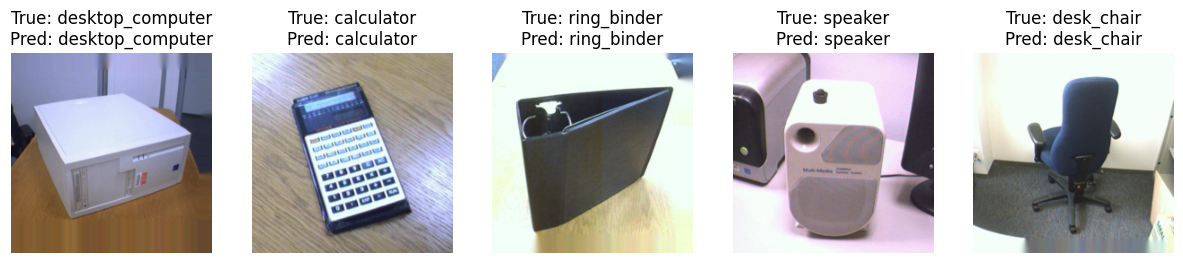

Accuracy of DSLR model on DSLR domain: 99.60%


<Figure size 1000x800 with 0 Axes>

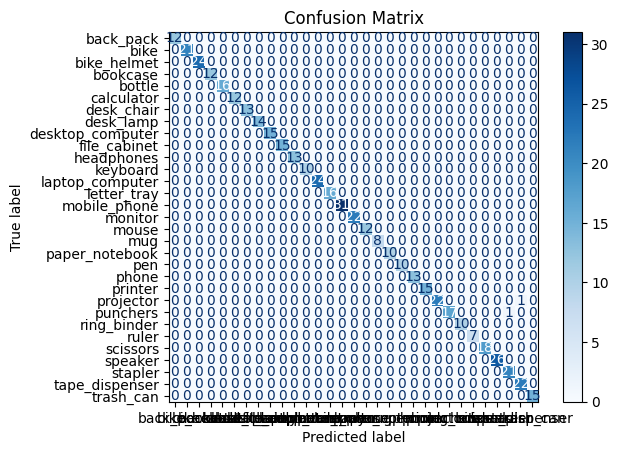

Accuracy of DSLR model on Webcam domain: 98.87%


<Figure size 1000x800 with 0 Axes>

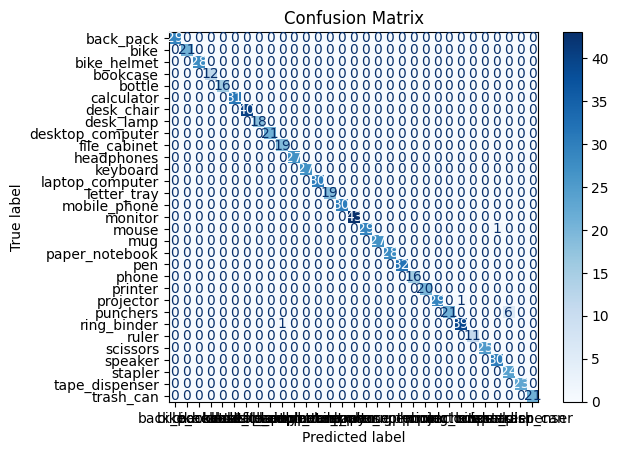

In [ ]:
model = ViTDomainAdaptation(num_classes=len(classes)).to(device)
construct_experiment(model, dslr_loader, dslr_train_loader, dslr_valid_loader, webcam_loader, ("DSLR", "Webcam"), device, num_epochs, learning_rate)

### Webcam

Webcam model on Amazon domain
Train Webcam -> Amazon


100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


Epoch [1/20], Total Loss: 22.3210, Class Loss: 21.7837, Coral Loss: 5.3739
Validation Loss: 0.4335, Validation Accuracy: 97.48%


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Epoch [2/20], Total Loss: 2.2035, Class Loss: 1.6748, Coral Loss: 5.2864
Validation Loss: 0.2911, Validation Accuracy: 98.74%


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Epoch [3/20], Total Loss: 0.9314, Class Loss: 0.5721, Coral Loss: 3.5931
Validation Loss: 0.1620, Validation Accuracy: 100.00%


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Epoch [4/20], Total Loss: 0.5597, Class Loss: 0.3219, Coral Loss: 2.3773
Validation Loss: 0.1555, Validation Accuracy: 100.00%


100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


Epoch [5/20], Total Loss: 0.3212, Class Loss: 0.1189, Coral Loss: 2.0231
Validation Loss: 0.2848, Validation Accuracy: 98.11%


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Epoch [6/20], Total Loss: 0.2183, Class Loss: 0.0562, Coral Loss: 1.6214
Validation Loss: 0.1702, Validation Accuracy: 98.74%


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Epoch [7/20], Total Loss: 0.1776, Class Loss: 0.0479, Coral Loss: 1.2967
Validation Loss: 0.1420, Validation Accuracy: 99.37%


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Epoch [8/20], Total Loss: 0.1528, Class Loss: 0.0374, Coral Loss: 1.1537
Validation Loss: 0.1376, Validation Accuracy: 99.37%


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Epoch [9/20], Total Loss: 0.1307, Class Loss: 0.0342, Coral Loss: 0.9648
Validation Loss: 0.1309, Validation Accuracy: 99.37%


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Epoch [10/20], Total Loss: 0.1186, Class Loss: 0.0303, Coral Loss: 0.8826
Validation Loss: 0.1376, Validation Accuracy: 99.37%


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Epoch [11/20], Total Loss: 0.1047, Class Loss: 0.0263, Coral Loss: 0.7842
Validation Loss: 0.1357, Validation Accuracy: 99.37%


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Epoch [12/20], Total Loss: 0.0979, Class Loss: 0.0243, Coral Loss: 0.7355
Validation Loss: 0.1405, Validation Accuracy: 98.74%


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Epoch [13/20], Total Loss: 0.0895, Class Loss: 0.0226, Coral Loss: 0.6692
Validation Loss: 0.1424, Validation Accuracy: 98.74%


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Epoch [14/20], Total Loss: 0.0814, Class Loss: 0.0201, Coral Loss: 0.6130
Validation Loss: 0.1466, Validation Accuracy: 98.74%


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Epoch [15/20], Total Loss: 0.0751, Class Loss: 0.0173, Coral Loss: 0.5778
Validation Loss: 0.1555, Validation Accuracy: 98.74%


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Epoch [16/20], Total Loss: 0.0686, Class Loss: 0.0167, Coral Loss: 0.5191
Validation Loss: 0.1577, Validation Accuracy: 98.74%


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Epoch [17/20], Total Loss: 0.0631, Class Loss: 0.0159, Coral Loss: 0.4721
Validation Loss: 0.1644, Validation Accuracy: 98.74%


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Epoch [18/20], Total Loss: 0.0628, Class Loss: 0.0151, Coral Loss: 0.4769
Validation Loss: 0.1657, Validation Accuracy: 98.74%


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Epoch [19/20], Total Loss: 0.0571, Class Loss: 0.0137, Coral Loss: 0.4335
Validation Loss: 0.1700, Validation Accuracy: 98.74%


100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


Epoch [20/20], Total Loss: 0.0527, Class Loss: 0.0132, Coral Loss: 0.3949
Validation Loss: 0.1638, Validation Accuracy: 98.74%
Visualizing Webcam model on Amazon domain


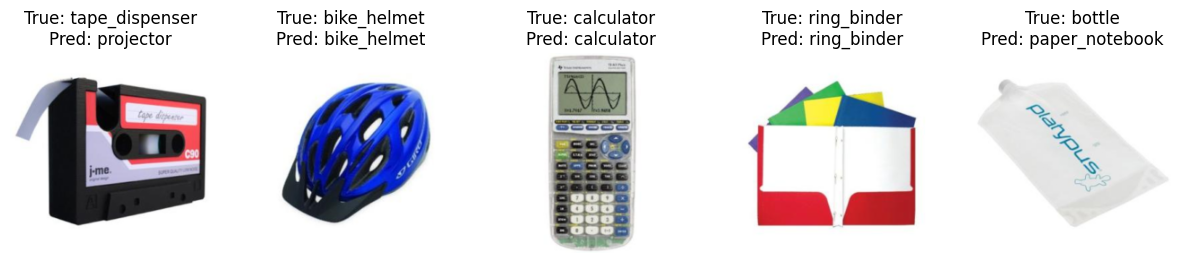

Accuracy of Webcam model on Webcam domain: 99.75%


<Figure size 1000x800 with 0 Axes>

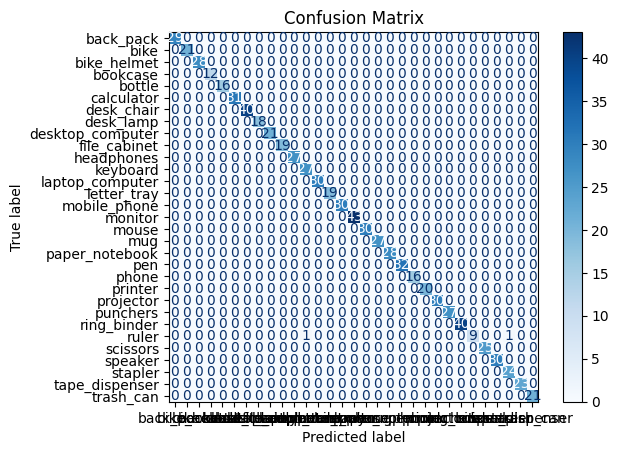

Accuracy of Webcam model on Amazon domain: 66.70%


<Figure size 1000x800 with 0 Axes>

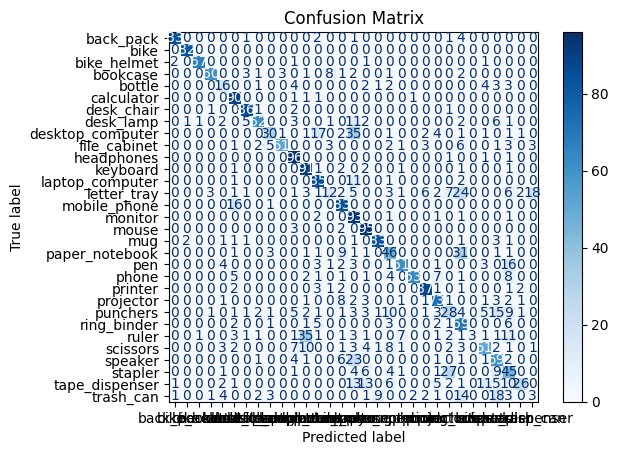

In [ ]:
model = ViTDomainAdaptation(num_classes=len(classes)).to(device)
construct_experiment(model, webcam_loader, webcam_train_loader, webcam_valid_loader, amazon_loader, ("Webcam", "Amazon"), device, num_epochs, learning_rate)

Webcam model on DSLR domain
Train Webcam -> DSLR


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


Epoch [1/20], Total Loss: 23.6241, Class Loss: 23.3020, Coral Loss: 3.2201
Validation Loss: 0.9353, Validation Accuracy: 94.34%


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


Epoch [2/20], Total Loss: 1.1858, Class Loss: 0.8207, Coral Loss: 3.6512
Validation Loss: 0.2781, Validation Accuracy: 98.11%


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


Epoch [3/20], Total Loss: 1.0389, Class Loss: 0.6683, Coral Loss: 3.7063
Validation Loss: 0.3100, Validation Accuracy: 98.11%


100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Epoch [4/20], Total Loss: 0.4515, Class Loss: 0.2561, Coral Loss: 1.9539
Validation Loss: 0.1431, Validation Accuracy: 100.00%


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


Epoch [5/20], Total Loss: 0.6094, Class Loss: 0.4223, Coral Loss: 1.8715
Validation Loss: 0.2985, Validation Accuracy: 97.48%


100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Epoch [6/20], Total Loss: 0.4186, Class Loss: 0.2456, Coral Loss: 1.7301
Validation Loss: 0.2145, Validation Accuracy: 98.11%


100%|██████████| 16/16 [00:17<00:00,  1.06s/it]


Epoch [7/20], Total Loss: 0.3186, Class Loss: 0.1576, Coral Loss: 1.6102
Validation Loss: 0.2232, Validation Accuracy: 99.37%


100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Epoch [8/20], Total Loss: 0.4347, Class Loss: 0.2967, Coral Loss: 1.3798
Validation Loss: 0.4056, Validation Accuracy: 96.23%


100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Epoch [9/20], Total Loss: 0.6047, Class Loss: 0.4751, Coral Loss: 1.2956
Validation Loss: 0.2415, Validation Accuracy: 98.74%


100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Epoch [10/20], Total Loss: 0.5763, Class Loss: 0.4345, Coral Loss: 1.4183
Validation Loss: 0.1129, Validation Accuracy: 99.37%


100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Epoch [11/20], Total Loss: 0.6292, Class Loss: 0.5028, Coral Loss: 1.2640
Validation Loss: 0.3478, Validation Accuracy: 98.74%


100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Epoch [12/20], Total Loss: 0.2930, Class Loss: 0.1762, Coral Loss: 1.1682
Validation Loss: 0.0933, Validation Accuracy: 100.00%


100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Epoch [13/20], Total Loss: 0.1576, Class Loss: 0.0277, Coral Loss: 1.2986
Validation Loss: 0.1223, Validation Accuracy: 99.37%


100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Epoch [14/20], Total Loss: 0.1188, Class Loss: 0.0286, Coral Loss: 0.9022
Validation Loss: 0.0626, Validation Accuracy: 100.00%


100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Epoch [15/20], Total Loss: 0.1104, Class Loss: 0.0285, Coral Loss: 0.8191
Validation Loss: 0.0470, Validation Accuracy: 100.00%


100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Epoch [16/20], Total Loss: 0.0982, Class Loss: 0.0228, Coral Loss: 0.7536
Validation Loss: 0.0434, Validation Accuracy: 100.00%


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


Epoch [17/20], Total Loss: 0.0893, Class Loss: 0.0223, Coral Loss: 0.6701
Validation Loss: 0.0429, Validation Accuracy: 100.00%


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


Epoch [18/20], Total Loss: 0.0802, Class Loss: 0.0196, Coral Loss: 0.6063
Validation Loss: 0.0402, Validation Accuracy: 100.00%


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


Epoch [19/20], Total Loss: 0.0776, Class Loss: 0.0178, Coral Loss: 0.5971
Validation Loss: 0.0416, Validation Accuracy: 100.00%


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


Epoch [20/20], Total Loss: 0.0736, Class Loss: 0.0178, Coral Loss: 0.5583
Validation Loss: 0.0439, Validation Accuracy: 100.00%
Visualizing Webcam model on DSLR domain


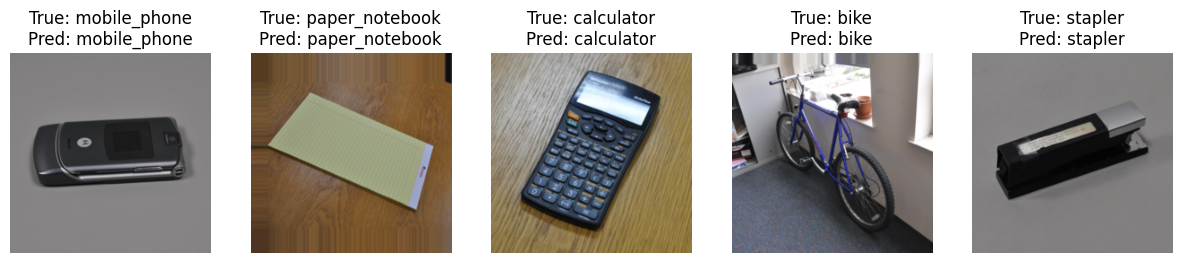

Accuracy of Webcam model on Webcam domain: 100.00%


<Figure size 1000x800 with 0 Axes>

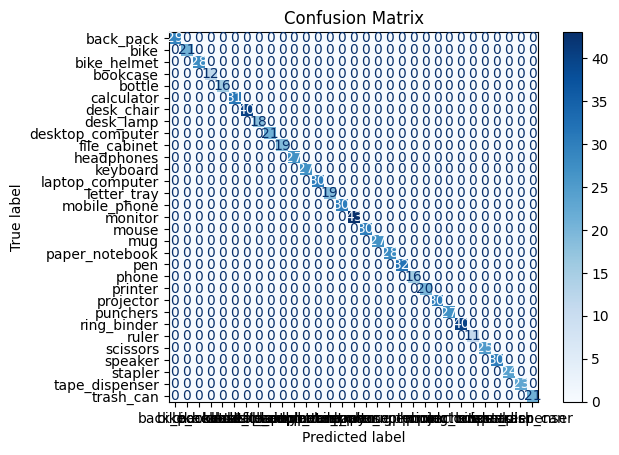

Accuracy of Webcam model on DSLR domain: 100.00%


<Figure size 1000x800 with 0 Axes>

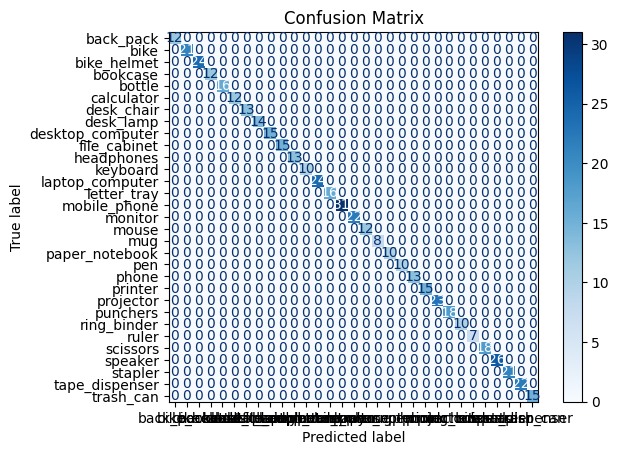

In [ ]:
model = ViTDomainAdaptation(num_classes=len(classes)).to(device)
construct_experiment(model, webcam_loader, webcam_train_loader, webcam_valid_loader, dslr_loader, ("Webcam", "DSLR"), device, num_epochs, learning_rate)